In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings

In [2]:
!pip install prophet

  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/12/ff/a04156f4ca3d18bd005c73f79e86e0684346fbc2aea856429c3e49f2828e/prophet-1.1.6-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/2a/80/04b3989f055e555737b3b6944f02112e90cfc4f2e53c763771dded22e684/cmdstanpy-1.2.5-py3-none-any.whl.metadata
  Obtaining dependency information for holidays<1,>=0.25 from https://files.pythonhosted.org/packages/0a/2a/21b671feb22e708f4368518b8212a9d5993fc87385d14b0b195058114104/holidays-0.62-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-resources from https://files.pythonhosted.org/packages/e1/6a/4604f9ae2fa62ef47b9de2fa5ad599589d28c9fd1d335f32759813dfa91e/importlib_resources-6.4.5-py3-none-any.whl.metadata
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://files.pythonhosted.org/packages/56/87/37a80e4d5bd453c33262d8fb618b6840fd98d24ed0

In [4]:
from prophet import Prophet

In [11]:
pjme = pd.read_csv('PJME_hourly.csv', 
                  index_col=[0],
                  parse_dates=[0])

In [12]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


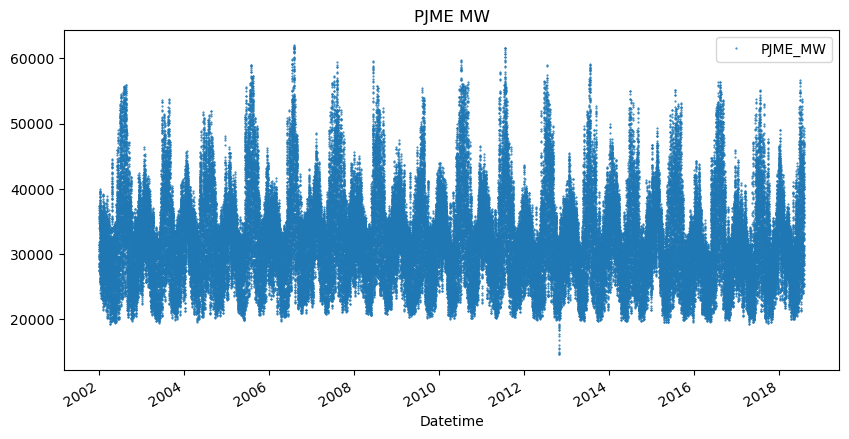

In [15]:
color_pal = sns.color_palette()
pjme.plot(style='.',
         figsize=(10, 5),
         ms=1,
         color=color_pal[0],
         title='PJME MW')
plt.show();

## Time Series Features

In [21]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                       'Wednesday',
                                       'Thursday', 'Friday',
                                        'Saturday', 'Sunday'],
                           ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['week_number'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 * df.date.dt.day - 320)%1300
    
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                         labels=['Spring', 'Summer', 'Fall', 'Winter']
                    )
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
           'dayofyear', 'dayofmonth', 'week_number', 'weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X,y], axis=1)    

In [22]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,week_number,weekday,season,PJME_MW
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Summer,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Summer,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Summer,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Summer,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Summer,24860.0


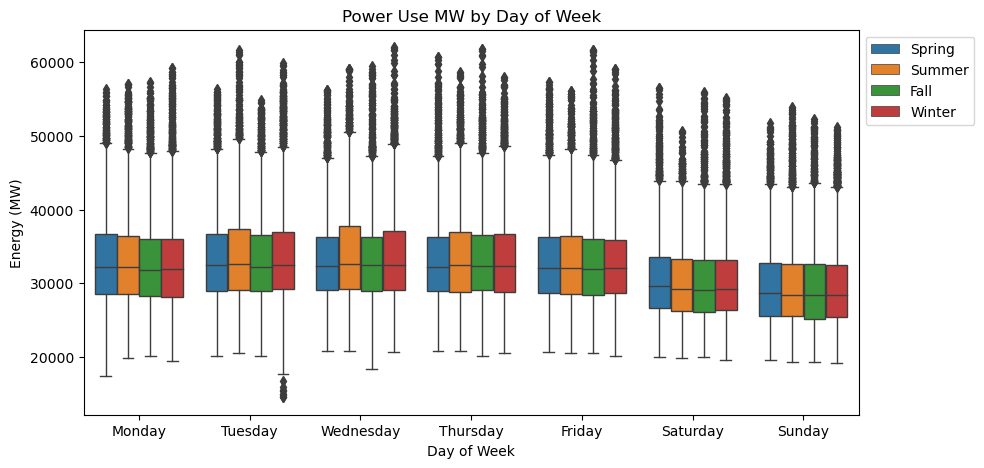

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
           x='weekday',
           y='PJME_MW',
           hue='season',
           ax=ax,
           linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

## Train Test Split

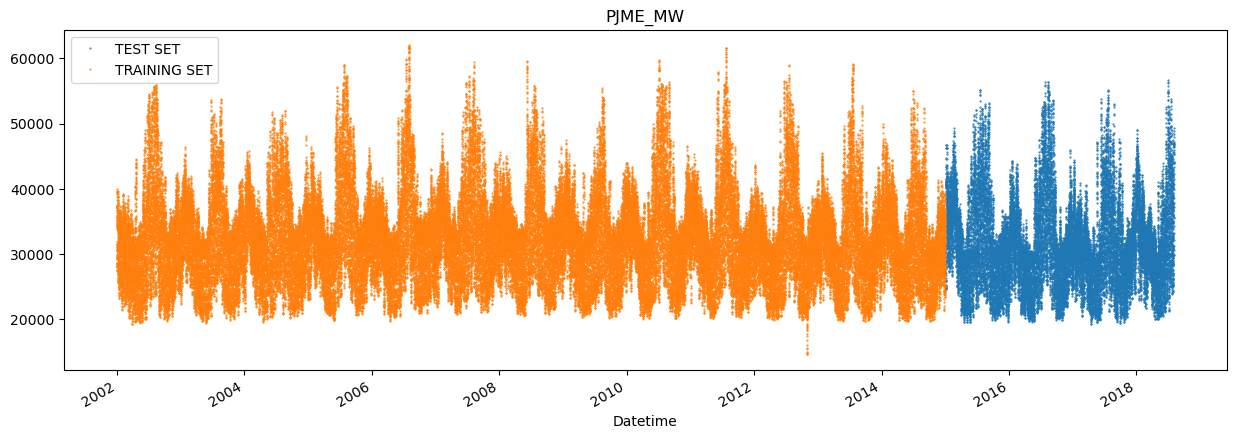

In [27]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so we can see where we have the split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
         how='outer') \
    .plot(figsize=(15, 5), title='PJME_MW', style='.', ms=1)
plt.show()

## Prophet Model

Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns prior to feeding it into the model
* Datetime column named : ds
* Target : y

In [29]:
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                    'PJME_MW' : 'y'})

In [30]:
pjme_train_prophet.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [31]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

18:30:05 - cmdstanpy - INFO - Chain [1] start processing
18:32:37 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 17.5 s
Wall time: 2min 50s


In [32]:
# Predict with model using test set 
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                    'PJME_MW' : 'y'})

pjme_test_forecast = model.predict(pjme_test_prophet)

In [33]:
pjme_test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31214.420813,23921.195343,32854.861692,31214.420813,31214.420813,-2835.417939,-2835.417939,-2835.417939,-4430.360197,...,1281.390107,1281.390107,1281.390107,313.552151,313.552151,313.552151,0.0,0.0,0.0,28379.002874
1,2015-01-01 02:00:00,31214.383693,22554.159068,31487.728748,31214.383693,31214.383693,-4339.789544,-4339.789544,-4339.789544,-5927.274407,...,1272.632061,1272.632061,1272.632061,314.852802,314.852802,314.852802,0.0,0.0,0.0,26874.594149
2,2015-01-01 03:00:00,31214.346573,21524.394812,30929.757519,31214.346573,31214.346573,-5211.485567,-5211.485567,-5211.485567,-6790.348748,...,1262.668237,1262.668237,1262.668237,316.194944,316.194944,316.194944,0.0,0.0,0.0,26002.861007
3,2015-01-01 04:00:00,31214.309453,21509.516507,30352.873733,31214.309453,31214.309453,-5353.038520,-5353.038520,-5353.038520,-6922.239359,...,1251.622235,1251.622235,1251.622235,317.578604,317.578604,317.578604,0.0,0.0,0.0,25861.270933
4,2015-01-01 05:00:00,31214.272334,21751.058891,31112.261615,31214.272334,31214.272334,-4678.701426,-4678.701426,-4678.701426,-6237.335097,...,1239.629865,1239.629865,1239.629865,319.003806,319.003806,319.003806,0.0,0.0,0.0,26535.570907


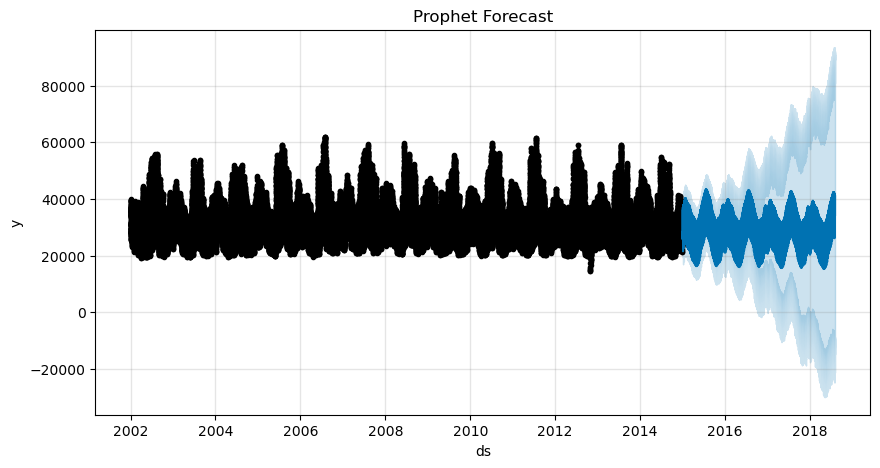

In [35]:
# Plot the forecast value obtained from model

fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_forecast, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

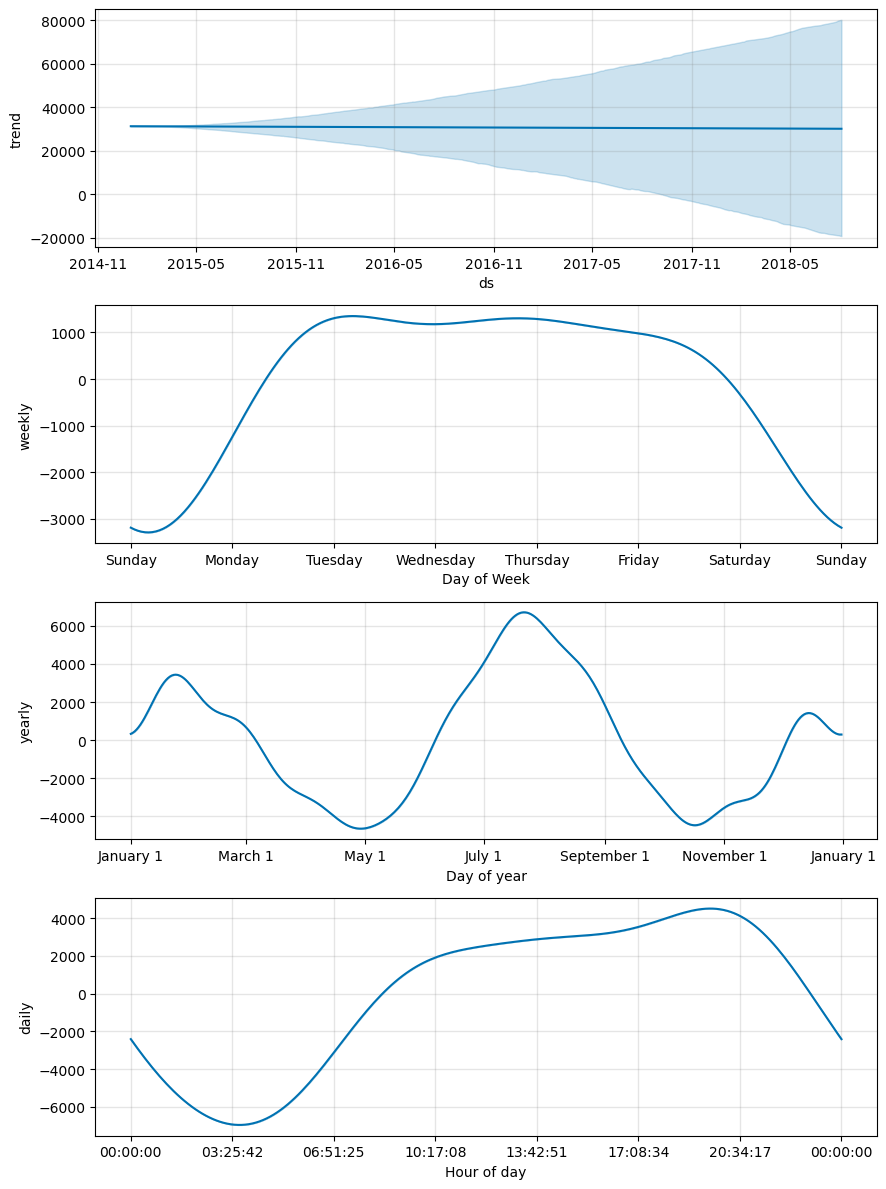

In [36]:
fig = model.plot_components(pjme_test_forecast)
plt.show()

## Compare Actual values and Forecast

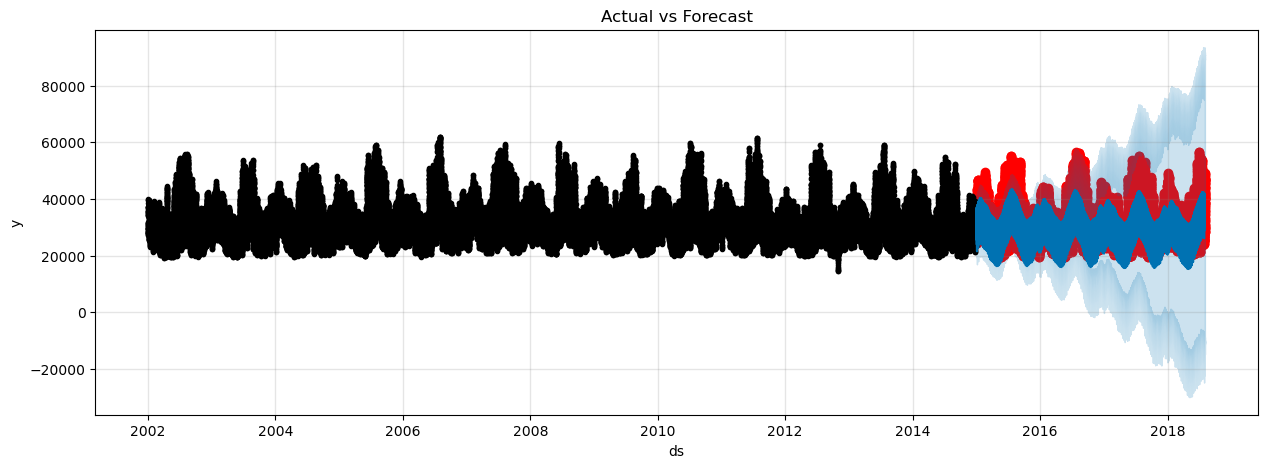

In [43]:
# Plot actuals and forecast
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_forecast, ax=ax)
ax.set_title('Actual vs Forecast');

## Evaluate Model with Error Metrics

In [44]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                          y_pred=pjme_test_forecast['yhat']))

6614.471677632393

In [46]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test_forecast['yhat'])

5181.449393612847